# Exploring Gender Biases in Word2vec 

This notebook defines genism's model and trains it with the Gutenburg and Wikipedia datasets. We also explore different embedding metrics to define a base comparision before we implement debiasing techniques. 


In [1]:
#library imports
import string
import numpy as np
from numpy.linalg import norm
import json
import tempfile
from sklearn.decomposition import PCA
!pip install torch
import torch
!pip install torchtext
from torchtext.data.utils import get_tokenizer

#gutenberg data import
# from gutenberg_data import get_urls, read_data_from_urls
!pip install gensim
#models import
from gensim.models import Word2Vec

# import custom_word2vec

#plots
import matplotlib as plt
import matplotlib.pyplot

print("done!")

done!


In [2]:
#had trouble importing file so copy pasted custom word2vec here
#imports
import torch
from torch import nn, optim, sigmoid
# import tensorflow
# from keras.preprocessing.sequence import skipgrams 
import matplotlib.pyplot as plt

#check which device pytorch will use, set default tensor type to cuda
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
print(f'Using {device} device')
# torch.set_default_tensor_type('torch.cuda.FloatTensor') #run on google colab

print("done!")

Using cpu device
done!


In [3]:
"""
Custum Word2Vec

For Zhao et al.'s and Savani et al.'s debiasing methods, we created our own model and skip-gram traning loops below.
"""

class skipgram(nn.Module):
    """
    defines the layers of the word2vec model
    
    Embedding Layer Target - target words to compare the context words (output embeddings)
    Embedding Layer Context - context words to compare to target words
    Linear - after the dot product of target and context layers, this linear layer transforms the output to 1 dim to compare with 1 = relevant pair, 0 - irrelevant pair labels 
    """
    
    def __init__(self, size_vocab, embedding_dim):
        super(skipgram, self).__init__()
        self.embeddings_target =  nn.Embedding(size_vocab+1, embedding_dim, max_norm=1).to(device) #what we care about
        self.embeddings_context = nn.Embedding(size_vocab+1, embedding_dim, max_norm=1).to(device) #used in loss calculation
        self.linear = nn.Linear(embedding_dim,1)
        

    def forward(self, target_tensor, context_tensor): #loss
        embedding_t = self.embeddings_target(target_tensor)
        embedding_c = self.embeddings_context(context_tensor)
        
        return torch.sigmoid(self.linear(torch.mul(embedding_t, embedding_c))).squeeze(1)

class Custom_Word2Vec:
    """
    defines the word2vec model
    
    hyperparameters: 
    - embedding_dim: embedding dimension (default 10)
    - LR: learning rate for optimizer (default 0.01)
    - window_size: window of context words to generate skip-gram pairs (default 10)
    - EPOCHS: number of iterations to run training (default 10)
    """
    
    def __init__(self, sentance_tokens, embedding_dim=10, LR=0.01, window_size=10, EPOCHS=10):
        #hyperparamters
        self.window_size = window_size
        self.embedding_dim = embedding_dim
        self.lr = LR
        self.epochs = EPOCHS
        
        #data, corpus
        self.sentance_tokens = sentance_tokens
        self.corpus_vocab = self.corpus_vocab()
        self.size_vocab = len(self.corpus_vocab)
        
        #model, loss, optimizer
        self.model = skipgram(self.size_vocab, self.embedding_dim)
        self.loss_fcn = nn.BCELoss() # use binary cross entropy as the loss function
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr) #use stochiastic gradient descent

    
    def corpus_vocab(self):
        """
        define a dictionary where keys are words, and the values are the unique ids of the words
        """

        #count frequency of each word
        vocab_counts = {}
        for sentance in self.sentance_tokens:
            for word in sentance:
                vocab_counts[word] = vocab_counts.get(word, 0) + 1


        #create corpus by assigning unique ids
        i = 1
        corpus_vocab = {}
        for k, v in sorted(vocab_counts.items(), key=lambda item: item[1]):
            corpus_vocab[k] = i
            i+=1

        return corpus_vocab

    def create_target_context_pairs(self):
        """
        generate [(target, context), 1] pairs as positive samples - contextually relevant pair
        and [(target, random), 0] pairs as negative samples - contextually irrelevant pair
        """
        
        #get the word ids from the corpus for all the sentances
        word_ids_datatset = [[self.corpus_vocab[word] for word in sentance] for sentance in self.sentance_tokens]
        
        #generate skipgrams (pairs) for all sentances
        skip_grams = [skipgrams(word_ids, vocabulary_size=self.size_vocab, window_size=self.window_size) for word_ids in word_ids_datatset]
        
        return skip_grams
    
    def embedding(self, word):
        idx = self.corpus_vocab[word]
        embedding = self.model.embeddings_target(torch.Tensor([idx]).long())
        return embedding.detach().cpu().numpy()[0]
    
    def train(self, plot=True):
        
        skip_grams = self.create_target_context_pairs() #get pairs

        losses_epochs = []

        #loop over epochs
        for epoch in range(self.epochs):
            total_loss = 0
            
            #iterate through all target, context pairs
            for pairs, labels in skip_grams:
                # zero the gradients
                self.optimizer.zero_grad()

                # calculate loss 
                sentance_losses = []
                for i in range (len(pairs)): #pairs in a sentance
                    target_tensor = torch.Tensor([pairs[i][0]]).long() #target word
                    context_tensor =  torch.Tensor([pairs[i][1]]).long() #context word (true or random)
                    label = torch.Tensor([labels[i]]).float() # 1- relevant, 0 - irrelevent

                    output = self.model(target_tensor, context_tensor)
                    loss_pair = self.loss_fcn(output,label)
                    sentance_losses.append(loss_pair)


                #loss backward, optimizer step
                if sentance_losses:
                    loss = torch.sum(torch.stack(sentance_losses))
                    loss.backward()
                    total_loss+= loss.item()
                    self.optimizer.step()

            print('Epoch:', epoch+1, ' Training Loss:', total_loss)
            losses_epochs.append(total_loss)
        
        # plot loss over epochs
        if plot:
            epochs = [i+1 for i in range(self.epochs)]
            plt.plot(epochs,losses_epochs)
            plt.title('Loss vs Epochs for Word2Vec Skip-Gram Model')
            plt.xlabel('Epoch')
            plt.ylabel('Cost')
            plt.show()

"""

How to Use:
- define a Custom_Word2Vec instance with the hyperparamters
- call the .train() function
- acess trained embeddings via .embedding()


Example:
word_2_vec = Custom_Word2Vec([['he', 'was', 'cool'], ['she', 'loved', 'meat'], ['you', 'do', 'nothing']])
word_2_vec.train()
print ("embedding: ", word_2_vec.embedding('he'))

"""

'\n\nHow to Use:\n- define a Custom_Word2Vec instance with the hyperparamters\n- call the .train() function\n- acess trained embeddings via .embedding()\n\n\nExample:\nword_2_vec = Custom_Word2Vec([[\'he\', \'was\', \'cool\'], [\'she\', \'loved\', \'meat\'], [\'you\', \'do\', \'nothing\']])\nword_2_vec.train()\nprint ("embedding: ", word_2_vec.embedding(\'he\'))\n\n'

## 1 - Data Preprocessing

In [4]:
def create_tokens(data):
    """
    creates tokenized list with puncuation and digits removed and lowercase words 

    :param data: list of strings
    :return: a list of tokens 
    """ 
    tokens = []
    for sentance in data:
        sentance = sentance.translate(str.maketrans('', '', string.punctuation)) #remove punctuations
        sentance = sentance.translate(str.maketrans('', '', string.digits)) #remove digits
        tokenizer = get_tokenizer("basic_english", language="en") #remove unessasary characters, splits into spaces
        tokens.append(tokenizer(sentance))
  
    return tokens
  

**Gutenburg Dataset**

**Wikipedia Dataset**

## 2 - Define Word2Vec - Genism

**Define word 2 vec model** <br>

Using: Skip-gram training algorithm. 

Hyperparameters:
- min_freq: choosing the top N most frequent words - for easier training 
- size: embedding size. We use 300 as per Bolukbasi et al.
- window: the window used for looking at context and center words when traing the embeddings 

In [5]:
#Useful helper functions for model

def check_w_embedding(word_lists, model, printRemoved):
    '''
    checks if the embedding exists for the given word, and if not deletes it from the lists. 
    if printRemoved = true, it also declares the words that were not in the model embeddings. 
    '''
    new_w_lists = []
    
    for word_list in word_lists:
        new_w_l = []
        for w in word_list: 
            if w in model.wv.key_to_index:
                new_w_l.append(w)
            else:
                if printRemoved:
                    print ("Word", w, " is not in the model")
                    
        new_w_lists.append(new_w_l)
    
    return new_w_lists
    

def w_vec(word, model):
    '''
    returns the word embedding of the input word
    '''
    return model.wv[word]
   

def cos_sim(a,b):
    '''
    returns the cosine similarity between 2 word embeddings 
    '''
    return np.dot(a, b)/(norm(a)*norm(b))

Now, save the embeddings to use in debiasing. 

In [6]:
# with open('gutenburg_embeddings.txt', 'w') as f:
#     for idx, key in enumerate(list(model_g.wv.index_to_key)):
#         embedding = ' '.join(str(v) for v in model_g.wv.get_vector(key))
#         f.write(key + " " + embedding+"\n")

In [7]:
min_freq = 100
size = 300
window = 10


#wikipedia model
model_w = Word2Vec(min_count=min_freq, vector_size=size, window=window, sg=1) #sg=1 is the skip-gram training algorithm
# model_w.init_weights()

#Wikipedia
for file in range(2):
    f_name = 'Wiki_files/wikipedia-en-' + str(file) + '.json'
    print(f_name)
    f = open(f_name)
    sentences_wikipedia = []
    train_data = json.load(f)
    for article in train_data:        
        train_data_w = str(article).split('.')
        sentences_wikipedia += create_tokens(train_data_w)
    if file == 0:
        model_w.build_vocab(sentences_wikipedia)
    else:
        model_w.build_vocab(sentences_wikipedia,update=True)
        model_w.train(sentences_wikipedia, total_examples=model_w.corpus_count, epochs=5)
        model_w.update_weights()        


with open('wikipedia_embeddings.txt', 'w') as f:
    for idx, key in enumerate(list(model_w.wv.index_to_key)):
        embedding = ' '.join(str(v) for v in model_w.wv.get_vector(key))
        f.write(key + " " + embedding+"\n")
        
print("DONE")

Wiki_files/wikipedia-en-0.json
Wiki_files/wikipedia-en-1.json
DONE


## 3 - Define/Train Word2Vec - Custom

In [8]:
# gutenburg
embedding_dim=10
LR=0.01
window_size=2
EPOCHS=2

# word_2_vec_gutenburg = Custom_Word2Vec(sentences_gutenburg, embedding_dim, LR, window_size, EPOCHS)
# word_2_vec_gutenburg.train()

# check first embedding
# embedding_1 = word_2_vec_gutenburg.model.embeddings_target(torch.Tensor([1]).long())
# print ("embedding tensor: ", embedding_1.detach().cpu().numpy()[0])

## 4 - Measuring Bias

### 4.1 - Construct the g subspace

First, define gendered words and pairs ground truth (taken from Bolukbasi et al.) Using PCA, define the gendered subspace g, by taking the most prominent dimension. 

PCA variance ratio: [5.7072699e-01 2.9193205e-01 1.1047800e-01 2.6862960e-02 3.5985182e-14
 8.1956181e-15]
PCA singular values: [2.9743972e+00 2.1272848e+00 1.3086474e+00 6.4530003e-01 7.4687273e-07
 3.5643112e-07]


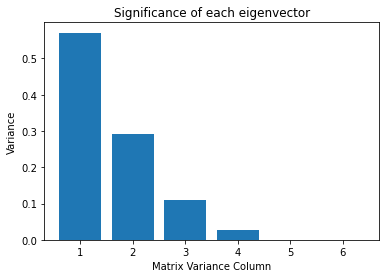

In [9]:
def gender_subspace_matrix(model, gender_pairs):
    '''
    create matrix of the gender space using gender pairs
        
    '''
    word_directions = []
    for word_pair in gender_pairs:
        f_word = w_vec(word_pair[0],model)
        m_word = w_vec(word_pair[1],model)
        dif = f_word-m_word
        word_directions.append(dif)

    return np.array(word_directions)


def define_vector_g(model, gender_pairs):
    word_directions = gender_subspace_matrix(model, gender_pairs) 

    #PCA of word direction
    pca = PCA(n_components=len(gender_pairs))
    pca.fit(word_directions)

    #print graph of PCA dimensions to determine how many dimensions should be kept
    print("PCA variance ratio:", pca.explained_variance_ratio_)
    print("PCA singular values:", pca.singular_values_)

    #plot graph of eigenvalue variance (basically how relevant each dimension was)
    len_var = len(pca.explained_variance_ratio_)
    plt.bar(range(1,len_var+1),pca.explained_variance_ratio_)
    plt.xlabel("Matrix Variance Column")
    plt.ylabel("Variance")
    plt.title("Significance of each eigenvector")

    #use the 1 most prominent dimension
    pca = PCA(n_components=1)
    pca.fit(word_directions)
    g = pca.components_
    
    return g

#gender pairs
#gender_pairs = [['she','he'],['her','his'],['woman','man'],['Mary','John'],['herself','himself'],['daughter','son'],['mother','father'],['gal','guy'],['girl','boy'],['female','male']]
gender_pairs = [['she','he'],['her','his'],['mother','father'],['daughter','son'], ['mother','father'],['female','male']]
# gender_pairs = check_w_embedding(gender_pairs, model_g, True)
# gender_pairs = check_w_embedding(gender_pairs, model_w, True)


#define g subspace for each dataset
# g_gutenburg = define_vector_g(model_g, gender_pairs)
g_wikipedia = define_vector_g(model_w,gender_pairs)

### 4.2 - Direct Bias

To measure direct bias, we will be using the equation from Bolukbasi et al. shown below. 

<img src="img/Direct_Bias.png" style="width:300px;float:left;"/>

We will use the same gender neutral words that have been collected from the paper which is 
denoted by N. As well, we will utilize the paper’s gender directions (vector from one word to another) 
which were verified by crowdsourcing. The gender subspace g will be the unit vector g that captures the
gender directions, computed by principal components in the paper. Finally, we will consider c, which is the 
strictness of bias, as a hyperparameter in our experiment. 

In [10]:
def calculate_direct_metric(gendered_word_set, model, c, g):
    '''
    calculate the direct bias using Bolukbasi et al.'s equation
    '''
    cosine_add = 0
    for word in gendered_word_set:
        cosine_add += np.abs(cos_sim(w_vec(word,model),g[0]))**c
    
    return cosine_add/len(gendered_word_set)
    

c = 1 #hyperparameter
#gendered_words = 'he, his, her, she, him, man, women, men, woman, spokesman, wife, himself, son'
gendered_words = 'he, his, her, she, him, man, women, men, woman, spokesman, wife, himself, son, mother, father, chairman, daughter, husband, guy, girls, girl, boy, boys, brother, spokeswoman, female, sister, male, herself, brothers, dad, actress, mom, sons, girlfriend, daughters, lady, boyfriend, sisters, mothers, king, businessman, grandmother, grandfather, deer, ladies, uncle, males, congressman, grandson, bull, queen, businessmen, wives, widow, nephew, bride, females, aunt, prostate cancer, lesbian, chairwoman, fathers, moms, maiden, granddaughter, younger brother, lads, lion, gentleman, fraternity, bachelor, niece, bulls, husbands, prince, colt, salesman, hers, dude, beard, filly, princess, lesbians, councilman, actresses, gentlemen, stepfather, monks, ex girlfriend, lad, sperm, testosterone, nephews, maid, daddy, mare, fiance, fiancee, kings, dads, waitress, maternal, heroine, nieces, girlfriends, sir, stud, mistress, lions, estranged wife, womb, grandma, maternity, estrogen, ex boyfriend, widows, gelding, diva, teenage girls, nuns, czar, ovarian cancer, countrymen, teenage girl, penis, bloke, nun, brides, housewife, spokesmen, suitors, menopause, monastery, motherhood, brethren, stepmother, prostate, hostess, twin brother, schoolboy, brotherhood, fillies, stepson, congresswoman, uncles, witch, monk, viagra, paternity, suitor, sorority, macho, businesswoman, eldest son, gal, statesman, schoolgirl, fathered, goddess, hubby, stepdaughter, blokes, dudes, strongman, uterus, grandsons, studs, mama, godfather, hens, hen, mommy, estranged husband, elder brother, boyhood, baritone, grandmothers, grandpa, boyfriends, feminism, countryman, stallion, heiress, queens, witches, aunts, semen, fella, granddaughters, chap, widower, salesmen, convent, vagina, beau, beards, handyman, twin sister, maids, gals, housewives, horsemen, obstetrics, fatherhood, councilwoman, princes, matriarch, colts, ma, fraternities, pa, fellas, councilmen, dowry, barbershop, fraternal, ballerina'
gendered_words = gendered_words.split(", ")

#gendered_word_set_w = set(check_w_embedding([gendered_words],model_w,False)[0])
#gendered_word_set_g = set(check_w_embedding([gendered_words],model_g,False)[0])
#gendered_word_set = list(gendered_word_set_w.intersection(gendered_word_set_g))

# gendered_word_set = check_w_embedding([gendered_words],model_g,False)[0]
# print("gendered word set after filtering: ", gendered_word_set)

gendered_word_set = check_w_embedding([gendered_words],model_w,False)[0]
print("gendered word set after filtering: ", gendered_word_set)

# direct_gutenburg = calculate_direct_metric(gendered_word_set, model_g, c, g_gutenburg)
direct_wikipedia = calculate_direct_metric(gendered_word_set, model_w, c, g_wikipedia)

# print("Direct metric gutenburg:", direct_gutenburg)
print("Direct metric wiki:", direct_wikipedia)


gendered word set after filtering:  ['he', 'his', 'her', 'she', 'him', 'man', 'women', 'men', 'woman', 'spokesman', 'wife', 'himself', 'son', 'mother', 'father', 'chairman', 'daughter', 'husband', 'guy', 'girls', 'girl', 'boy', 'boys', 'brother', 'spokeswoman', 'female', 'sister', 'male', 'herself', 'brothers', 'dad', 'actress', 'mom', 'sons', 'girlfriend', 'daughters', 'lady', 'boyfriend', 'sisters', 'mothers', 'king', 'businessman', 'grandmother', 'grandfather', 'deer', 'ladies', 'uncle', 'males', 'congressman', 'grandson', 'bull', 'queen', 'businessmen', 'wives', 'widow', 'nephew', 'bride', 'females', 'aunt', 'lesbian', 'chairwoman', 'fathers', 'moms', 'maiden', 'granddaughter', 'lads', 'lion', 'gentleman', 'fraternity', 'bachelor', 'niece', 'bulls', 'husbands', 'prince', 'colt', 'salesman', 'hers', 'dude', 'beard', 'filly', 'princess', 'lesbians', 'councilman', 'actresses', 'gentlemen', 'stepfather', 'monks', 'lad', 'sperm', 'testosterone', 'nephews', 'maid', 'daddy', 'mare', 'king

### 4.3 - Indirect Bias

To measure indirect bias, we will be using the equation from Bolukbasi et al. shown below.

<img src="img/Indirect_Bias.png" style="width:300px;float:left;"/>

$w_{\perp}$ is defined as $w_{\perp} = w - w_{g}$ where $w_{g}=(w*g)*g$ as mentioned in the paper. We will be using the g subspace calculated above. As for the word pairs, we will run a few experiments. The first will be the most extreme words in the softball-football direction as mentioned in the paper. 

In [11]:
def calculate_indirect_metric(g, w, v):
    wg = np.dot(np.dot(w,g[0]),g[0])
    vg = np.dot(np.dot(v,g[0]),g[0])
    w_norm_vec = w-wg
    v_norm_vec = v-vg
    w_norm = norm(w_norm_vec)
    v_norm = norm(v_norm_vec)
    
    return (np.dot(w,v) - np.dot(w_norm_vec,v_norm_vec)/(w_norm*v_norm))/np.dot(w,v)

def compare_indirect_metrics(words, c_word, model,g):
    metrics=""
    for w in words:
        metrics+=str(calculate_indirect_metric(g, w_vec(c_word,model), w_vec(w,model)))+", "
    
    return metrics


#Future Experiment - Bolukbasi et al. 
#extreme_words_w = ['pitcher','bookkeeper', 'receptionist', 'nurse', 'waitress']
#compare_word_w = 'softball'
#extreme_words_m = ['footballer','businessman', 'pundit', 'maestro', 'cleric']
#compare_word_m = 'football'

#Experiment 1
extreme_words_w = ['family', 'sister', 'marriage', 'charm', 'relatives']
compare_word_w = 'clean'
extreme_words_m = ['paper', 'money', 'office', 'business', 'meeting']
compare_word_m = 'manager'


extreme_words_w,[compare_word_w] = check_w_embedding([extreme_words_w,[compare_word_w]], model_w, True)
metrics_w = compare_indirect_metrics(extreme_words_w, compare_word_w, model_w,g_wikipedia)
print("indirect β values for word 'clean':", metrics_w)

extreme_words_m,[compare_word_w] = check_w_embedding([extreme_words_m,[compare_word_m]], model_w, True)
metrics_m = compare_indirect_metrics(extreme_words_m, compare_word_m, model_w,g_wikipedia)
print("indirect β values for word 'manager':", metrics_m)
    

indirect β values for word 'clean': 0.9369643, 0.9179376, 0.93044645, 0.91845125, 0.9329243, 
indirect β values for word 'manager': 0.8986605, 0.9066216, 0.9126866, 0.9052932, 0.90433955, 


### 4.4 - WEAT Metric

To measure WEAT, we used the formula defined in Caliskan et al., which is an additional direct bias measure. 

<img src="img/WEAT.png" style="width:300px;float:left;"/>

In [12]:
def s_word_A_B(w,A,B,model):
    mean_A_sum = 0
    mean_B_sum = 0
    w_v = w_vec(w,model)
    
    for a in A:
        a_vec = w_vec(a,model)
        mean_A_sum +=cos_sim(w_v,a_vec)
    
    for b in B:
        b_vec = w_vec(b,model)
        mean_B_sum +=cos_sim(w_v,b_vec)
        
    return mean_A_sum/len(A) - mean_B_sum/len(B)

def s_X_Y_A_B(X,Y,A,B,model):
    sum_X = 0
    sum_Y = 0
    
    for x in X:
        sum_X += s_word_A_B(x,A,B,model)
        
    for y in Y:
        sum_Y += s_word_A_B(y,A,B,model)
    
    return sum_X - sum_Y

Now, lets run experiments on the models <br>
A and B are the attribute word groups (8 words each), and X,Y are the target words

In [13]:
#Experiment 1 - work/family
A = ['tie', 'manager', 'work', 'paper', 'money', 'office', 'business', 'meeting']
B = ['home', 'parents', 'children', 'family', 'sister', 'marriage', 'charm', 'relatives']
X = ['he', 'him']
Y = ['she', 'her'] 

A,B,X,Y = check_w_embedding([A,B,X,Y], model_w, True)
metric_exp_1_w = s_X_Y_A_B(X,Y,A,B,model_w)

print ("WEAT Exp 1:", metric_exp_1_w)

#Experiment 2 - professions
A_2 = ['police', 'manager', 'business', 'lawyers', 'engineer', 'program', 'builder', 'fire']
B_2 = ['teachers', 'clean', 'social', 'hair', 'nail', 'make', 'writer', 'library'] 

A_3,B_3,X,Y = check_w_embedding([A_2,B_2,X,Y], model_w, True)
metric_exp_2_w = s_X_Y_A_B(X,Y,A_2,B_2,model_w)

print ("WEAT Exp 2:", metric_exp_2_w)



WEAT Exp 1: 0.14803844969719648
WEAT Exp 2: 0.05329342791810632


In [14]:
!pip3 install pickle-mixin
import pickle


with open('larger_model_w', 'wb') as files:
    pickle.dump(model_w, files)

In [15]:


# def load_wiki_models():
#     # load models
#     with open('larger_model_w' , 'rb') as f:
#         model_w = pickle.load(f)
# #       with open('wiki_model/model_w_custom' , 'rb') as f:
# #           model_w_custom = pickle.load(f) 
# #       return model_w, model_w_custom
#     return model_w


model_w.save('larger_model_w_s')
# model_w = load_wiki_models()

In [22]:
class Critic(nn.Module):

    def __init__(self, sizein, num_deep=3, hid=32):
        super().__init__()
        self.fc0 = nn.Linear(sizein, hid)
        self.fcs = nn.ModuleList([nn.Linear(hid, hid) for _ in range(num_deep)])
        self.dropout = nn.Dropout(0.2)
        self.out = nn.Linear(hid, 1)

    def forward(self, t):
        t = t.reshape(1, -1)
        t = self.fc0(t)
        for fc in self.fcs:
            t = F.relu(fc(t))
            t = self.dropout(t)
        return self.out(t)
    
    
    

def adversarial_debiasing(model_state_dict, data, config, device):
    actor = load_model(data.num_features, config.get('hyperparameters', {}))
    actor.load_state_dict(model_state_dict)
    actor.to(device)
    hid = config['hyperparameters']['hid'] if 'hyperparameters' in config else 32
    critic = Critic(hid * config['adversarial']['batch_size'], num_deep=config['adversarial']['num_deep'], hid=hid)
    critic.to(device)
    critic_optimizer = optim.Adam(critic.parameters())
    critic_loss_fn = torch.nn.MSELoss()

    actor_optimizer = optim.Adam(actor.parameters(), lr=config['adversarial']['lr'])
    actor_loss_fn = torch.nn.BCELoss()

    for epoch in range(config['adversarial']['epochs']):
        for param in critic.parameters():
            param.requires_grad = True
        for param in actor.parameters():
            param.requires_grad = False
        actor.eval()
        critic.train()
        for step in range(config['adversarial']['critic_steps']):
            critic_optimizer.zero_grad()
            indices = torch.randint(0, data.X_valid.size(0), (config['adversarial']['batch_size'],))
            cX_valid = data.X_valid_gpu[indices]
            cy_valid = data.y_valid[indices]
            cp_valid = data.p_valid[indices]
            with torch.no_grad():
                scores = actor(cX_valid)[:, 0].reshape(-1).cpu().numpy()

            bias = compute_bias(scores, cy_valid.numpy(), cp_valid, config['metric'])

            res = critic(actor.trunc_forward(cX_valid))
            loss = critic_loss_fn(torch.tensor([bias], device=device), res[0])
            loss.backward()
            train_loss = loss.item()
            critic_optimizer.step()
            if (epoch % 10 == 0) and (step % 100 == 0):
                logger.info(f'=======> Critic Epoch: {(epoch, step)} loss: {train_loss}')

        for param in critic.parameters():
            param.requires_grad = False
        for param in actor.parameters():
            param.requires_grad = True
        actor.train()
        critic.eval()
        for step in range(config['adversarial']['actor_steps']):
            actor_optimizer.zero_grad()
            indices = torch.randint(0, data.X_valid.size(0), (config['adversarial']['batch_size'],))
            cy_valid = data.y_valid_gpu[indices]
            cX_valid = data.X_valid_gpu[indices]

            pred_bias = critic(actor.trunc_forward(cX_valid))
            bceloss = actor_loss_fn(actor(cX_valid)[:, 0], cy_valid)

            # loss = lam*abs(pred_bias) + (1-lam)*loss
            objloss = max(1, config['adversarial']['lambda']*(abs(pred_bias[0][0])-config['objective']['epsilon']+config['adversarial']['margin'])+1) * bceloss

            objloss.backward()
            train_loss = objloss.item()
            actor_optimizer.step()
            if (epoch % 10 == 0) and (step % 100 == 0):
                logger.info(f'=======> Actor Epoch: {(epoch, step)} loss: {train_loss}')

        if epoch % 10 == 0:
            with torch.no_grad():
                scores = actor(data.X_valid_gpu)[:, 0].reshape(-1, 1).cpu().numpy()
                _, best_adv_obj = get_best_thresh(scores, np.linspace(0, 1, 1001), data, config, valid=False, margin=config['adversarial']['margin'])
                logger.info(f'Objective: {best_adv_obj}')

    logger.info('Finding optimal threshold for Adversarial model.')
    with torch.no_grad():
        scores = actor(data.X_valid_gpu)[:, 0].reshape(-1, 1).cpu().numpy()

    best_adv_thresh, _ = get_best_thresh(scores, np.linspace(0, 1, 1001), data, config, valid=False, margin=config['adversarial']['margin'])

    logger.info('Evaluating Adversarial model on best threshold.')
    with torch.no_grad():
        labels = (actor(data.X_valid_gpu)[:, 0] > best_adv_thresh).reshape(-1, 1).cpu().numpy()
    results_valid = get_valid_objective(labels, data, config)
    logger.info(f'Results: {results_valid}')

    with torch.no_grad():
        labels = (actor(data.X_test_gpu)[:, 0] > best_adv_thresh).reshape(-1, 1).cpu().numpy()
    results_test = get_test_objective(labels, data, config)

    return results_valid, results_test




# Evaluate Adversarial
results_valid['adversarial'], results_test['adversarial'] = adversarial_debiasing(model_state_dict, data, config, device)

        
# Save Results
results_valid['config'] = config
logger.info(f'Validation Results: {results_valid}')
logger.info(f'Saving validation results to {config["experiment_name"]}_valid_output.json')
with open(Path('results') / f'{config["experiment_name"]}_valid_output.json', 'w') as fh:
    json.dump(results_valid, fh)


results_test['config'] = config
logger.info(f'Test Results: {results_test}')
logger.info(f'Saving validation results to {config["experiment_name"]}_test_output.json')
with open(Path('results') / f'{config["experiment_name"]}_test_output.json', 'w') as fh:
    json.dump(results_test, fh)

NameError: name 'model_state_dict' is not defined